In [1]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
#from sklearn.metrics import silhouette_score

result_dir = "../results/revision/analysis/"
plot_dir = "../results/revision/plots/"

cm = 1 / 2.54

import matplotlib.gridspec as gridspec

batch_palette = ["#EEE7A8", "cornflowerblue", "darkmagenta", "darkslategray"]
stage_palette = "magma_r"
palette_3colrs = ["#DAA327", "#BDE1CD", "#015799"]

plt.rcParams.update(
    {
        "font.size": 6,
        "axes.linewidth": 0.3,
        "xtick.major.size": 1.5,
        "xtick.major.width": 0.3,
        "ytick.major.size": 1.5,
        "ytick.major.width": 0.3,
    }
)

handletextpad = 0.1
point_size = 0.5
linewidth = 0.2
alpha = 0.1
point_linewidth = 0.0
handlesize = 0.3
dodge = True

In [29]:
# read in the csv file "wandb_subset_ARIs.csv"

df = pd.read_csv(result_dir + "performance/wandb_subset_ARIs.csv", sep=",")
# remove rows 8-10
df = df.drop([8, 9, 10])

# make a column for the number of cells (these are given in the last part of the run name after "subset")
df["n_cells"] = [x.split("_")[-1][6:] for x in df["Name"]]
df["n_cells"] = df["n_cells"].astype(int)

# remove columns Name and Index
df = df.drop(columns=["Name", "Index", "_wandb"])
# rename columns
df = df.rename(columns={"AdjustedRandIndex_fromMetaLabel": "ARI", "n_cells": "Number of cells"})

print(df)

         ARI  Number of cells
0   0.654657            42535
1   0.659651            42535
2   0.651396            28357
3   0.635885            28357
4   0.635487            14178
5   0.635007            14178
6   0.509691             5671
7   0.511926             5671
11  0.491517              567
12  0.659651            42535
13  0.640015            42535
14  0.570626            28357
15  0.587055            14178
16  0.417386             5671
17  0.427427              567


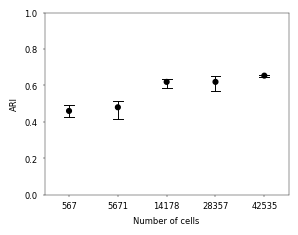

In [31]:
# plot the ARI over number of cells

pointplot_scale = 0.5
pointplot_errwidth = 0.7
pointplot_capsize = 0.2

fig, ax = plt.subplots(figsize=(8 * cm, 6 * cm))
sns.pointplot(
    x="Number of cells",
    y="ARI",
    data=df,
    ax=ax,
    color="black",
    linestyles="",
    scale=pointplot_scale,
    errwidth=pointplot_errwidth,
    capsize=pointplot_capsize,
)
ax.set_ylim(0, 1)
plt.show()

### calculate the clustering performance of MultiVI

In [2]:
import scvi
import scanpy as sc
import torch
import numpy as np
import pandas as pd
import anndata as ad
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score

save_dir = "../results/trained_models/"
data_name = "human_bonemarrow"

"""
Go through datasets and chosen models and compute reconstruction performances
"""
data_name = "human_bonemarrow"
adata = ad.read_h5ad("../../data/" + data_name + ".h5ad")
adata.X = adata.layers["counts"]
train_indides = np.where(adata.obs["train_val_test"] == "train")[0]
trainset = adata[train_indides, :].copy()
test_indides = np.where(adata.obs["train_val_test"] == "test")[0]
testset = adata[test_indides, :].copy()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)
trainset_all = trainset.copy()
df_subset_ids = pd.read_csv("../../data/" + data_name + "_data_subsets.csv")

subset_samples = [567, 5671, 14178, 28357, 42535, 56714]
subset_samples.reverse()
fraction_options = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]
fraction_options.reverse()
le = preprocessing.LabelEncoder()
le.fit(trainset.obs["cell_type"].values)

for count, fraction in enumerate(fraction_options):
    print("###")
    print("Fraction "+str(fraction))
    print("###")
    subset = subset_samples[count]
    train_indices = list(
        df_subset_ids[
            (df_subset_ids["fraction"] == fraction) & (df_subset_ids["include"] == 1)
        ]["sample_idx"].values
    )
    if fraction == 1.0:
        # trainset, testset, modality_switch, library = load_testdata_as_anndata(data_name)
        n_samples = len(trainset_all)
        trainset_all.var_names_make_unique()
        trainset_all.obs["modality"] = "paired"
        true_labels = le.transform(trainset_all.obs["cell_type"].values)
        scvi.model.MULTIVI.setup_anndata(trainset_all, batch_key="Site")
    else:
        trainset = adata[train_indices].copy()
        n_samples = len(train_indices)
        trainset.var_names_make_unique()
        trainset.obs["modality"] = "paired"
        true_labels = le.transform(trainset.obs["cell_type"].values)
        scvi.model.MULTIVI.setup_anndata(trainset, batch_key="Site")
    testset.var_names_make_unique()
    testset.obs["modality"] = "paired"
    scvi.model.MULTIVI.setup_anndata(testset, batch_key="Site")
    print("   loaded data")

    for random_seed in [0, 37, 8790]:
        model_name = "l20_e2_d2_rs" + str(random_seed) + "_subset" + str(subset)
        if fraction == 1.0:
            if random_seed == 0:
                model_name = "l20_e2_d2"
            else:
                model_name = "l20_e2_d2_rs" + str(random_seed)

        if fraction == 1.0:
            model = scvi.model.MULTIVI.load(
                save_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset_all
            )
            trainset_all.obsm["latent"] = model.get_latent_representation()
            # ARI
            sc.pp.neighbors(trainset_all, use_rep="latent", n_neighbors=15)
            sc.tl.leiden(
                trainset_all, key_added="clusters", resolution=1
            )
            cluster_labels = trainset_all.obs["clusters"].values.astype(int)
        else:
            model = scvi.model.MULTIVI.load(
                save_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset
            )
            trainset.obsm["latent"] = model.get_latent_representation()
            # ARI
            sc.pp.neighbors(trainset, use_rep="latent", n_neighbors=15)
            sc.tl.leiden(
                trainset, key_added="clusters", resolution=1
            )
            cluster_labels = trainset.obs["clusters"].values.astype(int)

        
        radj = adjusted_rand_score(true_labels, np.asarray(cluster_labels))
        print("ARI: " + str(radj))
        
        metrics_temp = pd.DataFrame(
            {
                "n_samples": [n_samples],
                "fraction": [fraction],
                "model": ["multiVI"],
                "random_seed": [random_seed],
                "ARI": radj,
            }
        )
        model = None
        if (count == 0) & (random_seed == 0):
            metrics_mvi = metrics_temp
        else:
            metrics_mvi = metrics_mvi.append(metrics_temp)
    trainset_all = None
    trainset = None

    metrics_mvi.to_csv(
        "../results/revision/analysis/performance/data_efficiency_clustering_mvi_subset"+str(subset)+".csv"
    )

print("done")


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###
Fraction 1.0
###
   loaded data
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2/model.pt already downloaded             


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0

ARI: 0.5402322304450794
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs37/model.pt already downloaded        


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5477289120121298
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs8790/model.pt already downloaded      


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_18902/3339311826.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5352972889451693
###
Fraction 0.75
###


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_18902/3339311826.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)


   loaded data
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs0_subset42535/model.pt already        
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5341187993802892
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs37_subset42535/model.pt already       
         downloaded                                                                                                


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_18902/3339311826.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5435147750404734
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs8790_subset42535/model.pt already     
         downloaded                                                                                                


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_18902/3339311826.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5415337596682049
###
Fraction 0.5
###


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_18902/3339311826.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)


   loaded data
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs0_subset28357/model.pt already        
         downloaded                                                                                                


: 

In [2]:
import scvi
import scanpy as sc
import torch
import numpy as np
import pandas as pd
import anndata as ad
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score

save_dir = "../results/trained_models/"
data_name = "human_bonemarrow"

"""
Go through datasets and chosen models and compute reconstruction performances
"""
data_name = "human_bonemarrow"
adata = ad.read_h5ad("../../data/" + data_name + ".h5ad")
adata.X = adata.layers["counts"]
train_indides = np.where(adata.obs["train_val_test"] == "train")[0]
trainset = adata[train_indides, :].copy()
test_indides = np.where(adata.obs["train_val_test"] == "test")[0]
testset = adata[test_indides, :].copy()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)
df_subset_ids = pd.read_csv("../../data/" + data_name + "_data_subsets.csv")

subset_samples = [567, 5671, 14178, 28357]
subset_samples.reverse()
fraction_options = [0.01, 0.1, 0.25, 0.5]
fraction_options.reverse()
le = preprocessing.LabelEncoder()
le.fit(trainset.obs["cell_type"].values)

for count, fraction in enumerate(fraction_options):
    print("###")
    print("Fraction "+str(fraction))
    print("###")
    subset = subset_samples[count]
    train_indices = list(
        df_subset_ids[
            (df_subset_ids["fraction"] == fraction) & (df_subset_ids["include"] == 1)
        ]["sample_idx"].values
    )
    trainset = adata[train_indices].copy()
    n_samples = len(train_indices)
    trainset.var_names_make_unique()
    trainset.obs["modality"] = "paired"
    true_labels = le.transform(trainset.obs["cell_type"].values)
    scvi.model.MULTIVI.setup_anndata(trainset, batch_key="Site")
    testset.var_names_make_unique()
    testset.obs["modality"] = "paired"
    scvi.model.MULTIVI.setup_anndata(testset, batch_key="Site")
    print("   loaded data")

    for random_seed in [0, 37, 8790]:
        model_name = "l20_e2_d2_rs" + str(random_seed) + "_subset" + str(subset)
        if fraction == 1.0:
            if random_seed == 0:
                model_name = "l20_e2_d2"
            else:
                model_name = "l20_e2_d2_rs" + str(random_seed)
        
        model = scvi.model.MULTIVI.load(
            save_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset
        )
        trainset.obsm["latent"] = model.get_latent_representation()
        # ARI
        sc.pp.neighbors(trainset, use_rep="latent", n_neighbors=15)
        sc.tl.leiden(
            trainset, key_added="clusters", resolution=1
        )
        cluster_labels = trainset.obs["clusters"].values.astype(int)

        
        radj = adjusted_rand_score(true_labels, np.asarray(cluster_labels))
        print("ARI: " + str(radj))
        
        metrics_temp = pd.DataFrame(
            {
                "n_samples": [n_samples],
                "fraction": [fraction],
                "model": ["multiVI"],
                "random_seed": [random_seed],
                "ARI": radj,
            }
        )
        model = None
        if random_seed == 0:
            metrics_mvi = metrics_temp
        else:
            metrics_mvi = metrics_mvi.append(metrics_temp)
    trainset_all = None
    trainset = None

    metrics_mvi.to_csv(
        "../results/revision/analysis/performance/data_efficiency_clustering_mvi_subset"+str(subset)+".csv"
    )

print("done")


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###
Fraction 0.5
###
   loaded data
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs0_subset28357/model.pt already        
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0

ARI: 0.571715006656332
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs37_subset28357/model.pt already       
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5533626713264825
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs8790_subset28357/model.pt already     
         downloaded                                                                                                


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_63197/2730434865.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5370041285954777
###
Fraction 0.25
###


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_63197/2730434865.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)


   loaded data
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs0_subset14178/model.pt already        
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.529077980411369
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs37_subset14178/model.pt already       
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5492211960155111
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs8790_subset14178/model.pt already     
         downloaded                                                                                                


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_63197/2730434865.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5693587123313539
###
Fraction 0.1
###


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_63197/2730434865.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)


   loaded data
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs0_subset5671/model.pt already         
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.4909848469297707
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs37_subset5671/model.pt already        
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5036115311799624
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs8790_subset5671/model.pt already      
         downloaded                                                                                                


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_63197/2730434865.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.5348804558137091
###
Fraction 0.01
###


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_63197/2730434865.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)


   loaded data
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs0_subset567/model.pt already          
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.3465503790037402
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs37_subset567/model.pt already         
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.3529342164393157
INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs8790_subset567/model.pt already       
         downloaded                                                                                                


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_63197/2730434865.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ARI: 0.365125794297447
done


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_63197/2730434865.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_mvi = metrics_mvi.append(metrics_temp)


### plot clustering performance over training set size

In [15]:
# for every subset, load the mvi clustering dataframes

subset_samples = [567, 5671, 14178, 28357, 42535, 56714]
for subset in subset_samples:
    df = pd.read_csv(
        "../results/revision/analysis/performance/data_efficiency_clustering_mvi_subset"
        + str(subset)
        + ".csv"
    )
    df = df.drop(columns=["Unnamed: 0"])
    df["Number of cells"] = df["n_samples"]
    df = df.drop(columns=["n_samples"])
    df["Subset size"] = subset
    if subset == 567:
        df_mvi = df
    else:
        if subset == 42535:
            # drop the accidental subset 56714
            df = df[df["Number of cells"] != 56714]
        df_mvi = pd.concat([df_mvi, df])

# drop everything except ARI and Number of cells
df_mvi = df_mvi[["ARI", "Number of cells"]]
df_mvi["Model"] = "MultiVI"
print(df_mvi)

        ARI  Number of cells    Model
0  0.346550              567  MultiVI
1  0.352934              567  MultiVI
2  0.365126              567  MultiVI
0  0.490985             5671  MultiVI
1  0.503612             5671  MultiVI
2  0.534880             5671  MultiVI
0  0.529078            14178  MultiVI
1  0.549221            14178  MultiVI
2  0.569359            14178  MultiVI
0  0.571715            28357  MultiVI
1  0.553363            28357  MultiVI
2  0.537004            28357  MultiVI
3  0.534119            42535  MultiVI
4  0.543515            42535  MultiVI
5  0.541534            42535  MultiVI
0  0.540232            56714  MultiVI
1  0.547729            56714  MultiVI
2  0.535297            56714  MultiVI


In [16]:
# read in the csv file "wandb_subset_ARIs.csv"

df = pd.read_csv(result_dir + "performance/wandb_subset_ARIs.csv", sep=",")
# remove rows 8-10
df = df.drop([8, 9, 10])

# make a column for the number of cells (these are given in the last part of the run name after "subset")
df["last_name"] = [x.split("_")[-1] for x in df["Name"]]
# if subset is not the first part of the last name, then the number of cells is 56714
df["n_cells"] = [x[6:] if "subset" in x else 56714 for x in df["last_name"]]
df["n_cells"] = df["n_cells"].astype(int)

# remove columns Name and Index
df = df.drop(columns=["Name", "Index", "_wandb", "last_name"])
# rename columns
df = df.rename(columns={"AdjustedRandIndex_fromMetaLabel": "ARI", "n_cells": "Number of cells"})

df["Model"] = "multiDGD"

print(df)

         ARI  Number of cells     Model
0   0.654657            42535  multiDGD
1   0.659651            42535  multiDGD
2   0.651396            28357  multiDGD
3   0.635885            28357  multiDGD
4   0.635487            14178  multiDGD
5   0.635007            14178  multiDGD
6   0.509691             5671  multiDGD
7   0.511926             5671  multiDGD
11  0.491517              567  multiDGD
12  0.659651            42535  multiDGD
13  0.640015            42535  multiDGD
14  0.570626            28357  multiDGD
15  0.587055            14178  multiDGD
16  0.417386             5671  multiDGD
17  0.427427              567  multiDGD
18  0.569867            56714  multiDGD
19  0.641487            56714  multiDGD
20  0.647253            56714  multiDGD


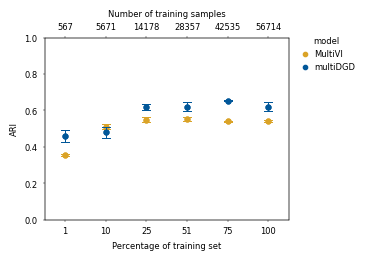

In [26]:
# combine the dataframes

df2 = pd.concat([df_mvi, df])
df2["fraction"] = ((df2["Number of cells"] / 56714 * 100) + 1).astype(int)
# change 101 to 100
df2["fraction"] = df2["fraction"].replace(101, 100)

# plot the ARI over number of cells

pointplot_scale = 0.5
pointplot_errwidth = 0.7
pointplot_capsize = 0.2
palette_2colrs = ["#DAA327", "#015799"]

fig, ax = plt.subplots(figsize=(8 * cm, 6 * cm))
sns.pointplot(
    x="fraction",
    y="ARI",
    data=df2,
    ax=ax,
    hue="Model",
    linestyles="",
    scale=pointplot_scale,
    errwidth=pointplot_errwidth,
    capsize=pointplot_capsize,
    palette=palette_2colrs,
    errorbar="se"
)

def percent_to_n(x):
    print(x)
    print(type(x))
    return int(x * 0.01 * 56714)
def n_to_percent(x):
    return int(x / 56714 * 100)
#secax = ax_list[-1].secondary_xaxis('top', functions=(percent_to_n, n_to_percent))
#secax.set_xlabel('Number of training samples')
ax2 = ax.twiny()
sns.pointplot(
    x="Number of cells",
    y="ARI",
    data=df2,
    ax=ax2,
    hue="Model",
    linestyles="",
    scale=pointplot_scale,
    errwidth=pointplot_errwidth,
    capsize=pointplot_capsize,
    palette=palette_2colrs,
    errorbar="se"
)
ax2.legend_.remove()
ax.legend(bbox_to_anchor=(1.0, 1.05),
                   loc='upper left', frameon=False,title='model',
                   markerscale=handlesize*3,
                   handletextpad=handletextpad*2)#.set_visible(False)
#ax_list[-1].text(30, 1.01, 'placeholder', fontdict={'color': 'red'})
ax.set_xlabel('Percentage of training set')
ax2.set_xlabel('Number of training samples')
ax.set_ylim(0, 1)

# save this figure
fig.savefig(plot_dir + "data_efficiency_clustering_mvi_multiDGD.png", dpi=300, bbox_inches="tight")